### Imports


In [23]:
!pip -q install pm4py
!apt -q install graphviz

Reading package lists...
Building dependency tree...
Reading state information...
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.


In [24]:
import pm4py
import pandas as pd
import os
import pprint as pp
import uuid
import networkx as nx
import numpy as np
import time

from pm4py.algo.simulation.playout.petri_net import algorithm as simulator
from pm4py.objects.petri_net.utils.final_marking import discover_final_marking
from pm4py.objects.petri_net.utils.initial_marking import discover_initial_marking

from pm4py.objects.petri_net.obj import PetriNet
from pm4py.objects.petri_net.utils import petri_utils
from pm4py.objects.petri_net.utils.petri_utils import get_transition_by_name
from pm4py.objects.petri_net.utils.final_marking import discover_final_marking
from pm4py.objects.petri_net.utils.initial_marking import discover_initial_marking
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
from pm4py.algo.conformance.tokenreplay import algorithm as token_based_replay
from pm4py.objects.bpmn.layout.variants.graphviz import Parameters as bpmn_layouter_parameters
from pm4py.objects.bpmn.layout import layouter as bpmn_layouter
from pm4py.objects.bpmn.exporter import exporter as bpmn_exporter

from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator



### Helper Funtions

In [25]:
# Helper Methods
def get_model_from_bpmn_file(file_name):
  bpmn = pm4py.read_bpmn(file_name)
  net, im, fm = pm4py.convert_to_petri_net(bpmn)
  model_dict = {}
  model_dict['bpmn'] = bpmn
  model_dict['net']= net
  model_dict['im'] = im
  model_dict['fm'] = fm
  return model_dict

def get_model_from_petri_net_file(file_name):
  model_dict = {}
  model_dict['net']= pm4py.read_pnml(file_name)[0]
  model_dict['im'] = discover_initial_marking(model_dict['net'])
  model_dict['fm'] = discover_final_marking(model_dict['net'])
  model_dict['bpmn'] = pm4py.convert_to_bpmn(model_dict['net'], model_dict['im'], model_dict['fm'])
  return model_dict

def get_event_log_from_file(file_name):
  log = pm4py.read_xes(file_name)
  log['time:timestamp'] = pd.date_range('2015-02-26 21:42:53', freq='5min', periods=len(log))
  return log

def view_petri_net(model_dict):
  pm4py.view_petri_net(model_dict['net'], model_dict['im'], model_dict['fm'])

def view_bpmn(model_dict):
  pm4py.view_bpmn(model_dict['bpmn'])

def convert_model_to_networkx(model_dict):
  return pm4py.convert_petri_net_to_networkx(model_dict['net'], model_dict['im'], model_dict['fm'])

NUMBER_OF_SIMULATED_TRACES = 100

def generate_fitting_event_log(model_dict):
  simulated_log = simulator.apply(model_dict['net'], model_dict['im'], final_marking= model_dict['fm'], variant=simulator.Variants.BASIC_PLAYOUT, parameters={simulator.Variants.BASIC_PLAYOUT.value.Parameters.NO_TRACES: NUMBER_OF_SIMULATED_TRACES})
  simulated_df = pm4py.convert_to_dataframe(simulated_log)
  return simulated_df

def merge_event_logs(event_log1, event_log2):
  event_log = event_log1.copy()
  event_log["case:concept:name"] = event_log["case:concept:name"] + 'event_log1'
  event_log_merged = pd.concat([event_log, event_log2.copy()], ignore_index=True)
  return event_log_merged


def discover_model_inductive(event_log):
  net, im, fm = pm4py.discover_petri_net_inductive(event_log)
  model_dict = {}
  model_dict['net']= net
  model_dict['im'] = im
  model_dict['fm'] = fm
  model_dict['bpmn'] = pm4py.convert_to_bpmn(model_dict['net'], model_dict['im'], model_dict['fm'])
  return model_dict


def fitness_alignments(event_log, model_dict):
  return pm4py.fitness_alignments(event_log, model_dict['net'], model_dict['im'], final_marking= model_dict['fm'])

def precision_alignments(event_log, model_dict):
 return pm4py.precision_alignments(event_log, model_dict['net'], model_dict['im'], final_marking= model_dict['fm'])

def generalization(event_log, model_dict):
  return generalization_evaluator.apply(event_log, model_dict['net'], model_dict['im'], final_marking= model_dict['fm'])

def simplicity(model_dict):
  return simplicity_evaluator.apply(model_dict['net'])

def evaluation(event_log, model_dict):
  fitne = fitness_alignments(event_log, model_dict)['log_fitness']
  preci = precision_alignments(event_log, model_dict)
  gener = generalization(event_log, model_dict)
  simpl = simplicity(model_dict)
  pp.pprint(f"Fitness: {fitne}")
  pp.pprint(f"Precision: {preci}")
  pp.pprint(f"Generalization: {gener}")
  pp.pprint(f"Simplicity: {simpl}")

def evaluation_df(log_gold, log_broken, log_combi, model_dict, model_name, model_type, exec_time):

  fitness_gold = fitness_alignments(log_gold, model_dict)['log_fitness']
  precision_gold = precision_alignments(log_gold, model_dict)
  generalization_gold = generalization(log_gold, model_dict)

  fitness_broken = fitness_alignments(log_broken, model_dict)['log_fitness']
  precision_broken = precision_alignments(log_broken, model_dict)
  generalization_broken = generalization(log_broken, model_dict)

  fitness_combi = fitness_alignments(log_combi, model_dict)['log_fitness']
  precision_combi = precision_alignments(log_combi, model_dict)
  generalization_combi = generalization(log_combi, model_dict)

  simpli = simplicity(model_dict)

  # Sample data
  data = {
    "Model": [model_name, model_name, model_name],
    "Model type": [model_type, model_type, model_type],
    "Log": ["gold", "broken", "combi"],
    "Fitness": [fitness_gold, fitness_broken, fitness_combi],
    "Precision": [precision_gold, precision_broken, precision_combi],
    "Generalization": [generalization_gold, precision_combi, generalization_combi],
    "Simplicity": [simpli, simpli, simpli],
    "Edit Distance": [None, None, None],
    "Execution Time Average": [exec_time, exec_time, exec_time],
  }

  # Create the DataFrame
  return pd.DataFrame(data)

#### Get Models

In [26]:
# get_model_gold() returns the model N1_gold or M1_gold (they are both encapsulated inside a dictionary)
def get_model_gold():
  net_gold = PetriNet('model_gold')

  def trans(name):
    return get_transition_by_name(net_gold, name)

  def pla(name):
    return get_place_by_name(net_gold, name)

  def arc_from_via_to(fr, via, to, net):
    petri_utils.add_arc_from_to(pla(fr), trans(via), net)
    petri_utils.add_arc_from_to(trans(via), pla(to), net)


  for place in range(1,18):
    petri_utils.add_place(net_gold, f'p{place}')

  transition_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'tau1', 'tau2', 'tau3', 'tau4', 'tau5', 'tau6']
  for trans_name in transition_names:
    petri_utils.add_transition(net_gold, trans_name, trans_name)

  arc_from_via_to('p2', 'tau1', 'p12', net_gold)
  arc_from_via_to('p12', 'B', 'p13', net_gold)
  arc_from_via_to('p13', 'D', 'p14', net_gold)
  petri_utils.add_transition(net_gold, 'E2', 'E2')
  arc_from_via_to('p14', 'E2', 'p15', net_gold)
  arc_from_via_to('p14', 'tau2', 'p15', net_gold)
  arc_from_via_to('p15', 'tau3', 'p10', net_gold)

  petri_utils.add_arc_from_to(trans('tau1'), pla('p16'), net_gold)
  arc_from_via_to('p16', 'C', 'p17', net_gold)
  petri_utils.add_arc_from_to(pla('p17'), trans('D'), net_gold)

  arc_from_via_to('p1', 'A', 'p2', net_gold)
  arc_from_via_to('p2', 'F', 'p3', net_gold)
  arc_from_via_to('p3', 'G', 'p4', net_gold)
  arc_from_via_to('p4', 'I', 'p5', net_gold)
  arc_from_via_to('p4', 'E', 'p5', net_gold)
  arc_from_via_to('p4', 'H', 'p5', net_gold)
  arc_from_via_to('p5', 'tau4', 'p6', net_gold)
  arc_from_via_to('p6', 'J', 'p7', net_gold)
  arc_from_via_to('p7', 'K', 'p8', net_gold)
  arc_from_via_to('p8', 'L', 'p9', net_gold)
  arc_from_via_to('p9', 'tau5', 'p6', net_gold)
  arc_from_via_to('p9', 'tau6', 'p10', net_gold)
  petri_utils.add_transition(net_gold, 'A2', 'A2')
  arc_from_via_to('p10', 'A2', 'p11', net_gold)

  for trans in net_gold.transitions:
    if "tau" in trans.name:
      trans.label = None
    if trans.name == 'A2':
      trans.label = 'A'
      trans.name ='A'
    if trans.name == 'E2':
      trans.label = 'E'
      trans.name ='E'

  model_dict = {}
  model_dict['net']= net_gold
  model_dict['im'] = discover_initial_marking(net_gold)
  model_dict['fm'] = discover_final_marking(net_gold)
  model_dict['bpmn'] = pm4py.convert_to_bpmn(model_dict['net'], model_dict['im'], model_dict['fm'])
  return model_dict

# get_model_brken() returns the model N1_broken or M1_broken (they are both encapsulated inside a dictionary)
def get_model_broken():
  net_broken = PetriNet('net_broken')

  def trans(name):
    return get_transition_by_name(net_broken, name)

  def pla(name):
    return get_place_by_name(net_broken, name)

  def arc_from_via_to(fr, via, to, net):
    petri_utils.add_arc_from_to(pla(fr), trans(via), net)
    petri_utils.add_arc_from_to(trans(via), pla(to), net)


  for place in ['p1', 'p2', 'p3', 'p4', 'p6', 'p8', 'p9', 'p10', 'p11', 'p14']:
    petri_utils.add_place(net_broken, place)


  transition_names = ['A', 'D', 'F', 'G', 'H', 'J', 'L', 'tau5', 'tau6']
  for trans_name in transition_names:
    petri_utils.add_transition(net_broken, trans_name, trans_name)


  arc_from_via_to('p1', 'A', 'p2', net_broken)
  arc_from_via_to('p2', 'F', 'p3', net_broken)
  arc_from_via_to('p3', 'G', 'p4', net_broken)
  arc_from_via_to('p4', 'H', 'p6', net_broken)
  arc_from_via_to('p6', 'J', 'p8', net_broken)
  arc_from_via_to('p8', 'L', 'p9', net_broken)
  arc_from_via_to('p9', 'tau5', 'p6', net_broken)
  arc_from_via_to('p9', 'tau6', 'p10', net_broken)
  petri_utils.add_transition(net_broken, 'A2', 'A2')
  arc_from_via_to('p10', 'A2', 'p11', net_broken)

  arc_from_via_to('p2', 'D', 'p14', net_broken)
  petri_utils.add_transition(net_broken, 'E2', 'E2')
  arc_from_via_to('p14', 'E2', 'p10', net_broken)


  for trans in net_broken.transitions:
    if "tau" in trans.name:
      trans.label = None
    if trans.name == 'A2':
      trans.label = 'A'
      trans.name ='A'
    if trans.name == 'E2':
      trans.label = 'E'
      trans.name ='E'

  model_dict = {}
  model_dict['net']= net_broken
  model_dict['im'] = discover_initial_marking(net_broken)
  model_dict['fm'] = discover_final_marking(net_broken)
  model_dict['bpmn'] = pm4py.convert_to_bpmn(model_dict['net'], model_dict['im'], model_dict['fm'])
  return model_dict

### Process Model Repair Algorithm

#### Repair Algorithm Helper Functions

In [27]:

def get_place_by_name(net: PetriNet, place_name):
    for p in net.places:
        if p.name == place_name:
            return p
    return None


# Get all the traces from a given log as a dictionary
# Key is the trace name
# Value is the corresponding log snippet sorted by time stamp
def get_traces_from_log(log):
    traces = {}
    for case_id in log['case:concept:name'].unique():
        trace = log[log['case:concept:name'] == case_id]
        trace = trace.sort_values(by=['time:timestamp'])
        traces[case_id] = trace
    return traces


# Returns true if the given trace fits the given process model
def trace_is_fit(trace, net, im, fm):
    fitness = pm4py.conformance.fitness_alignments(trace, net, im, fm)
    return fitness['averageFitness'] == 1.0


def get_reached_marking(trace, net, im, fm):
    parameters_tbr = {token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.STOP_IMMEDIATELY_UNFIT: True}#, token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.WALK_THROUGH_HIDDEN_TRANS: True}
    fitness = token_based_replay.apply(trace, net, im, fm, parameters=parameters_tbr)
    return fitness[0]['reached_marking']


# Returns the alignment between the given trace and the given process model as a list of tuples
def get_alignment(trace, net, im, fm):
    alignment = pm4py.conformance_diagnostics_alignments(trace,
                                                         net,
                                                         im,
                                                         fm,
                                                         variant_str=alignments.VERSION_DISCOUNTED_A_STAR)
    return alignment[0]['alignment']


# Returns true if the given move is a synchronous move
def is_sync_move(move):
    return move[0] == move[1] and move[0] != '>>' and move[1] != '>>'


# Returns true if the given move is a move on log
def is_move_on_log(move):
    return move[0] != move[1] and move[0] != '>>' and move[1] == '>>'


# Returns true if the given move is a move on model
def is_move_on_model(move):
    return move[0] != move[1] and move[0] == '>>' and move[1] != '>>'


# Returns true if the given move is a move on model and involves a skip / hidden transition
def is_move_on_model_skip(move):
    return is_move_on_model(move) and move[1] is None


# Returns net with an additional skip transition connected to the given in_places and out_places
# The skip transition's name should be unique
def add_skip_transition(net, in_place, out_place, skip_transition_name):
    petri_utils.add_transition(net, name=skip_transition_name, label=None)
    new_from_transition = get_transition_by_name(net, skip_transition_name)
    petri_utils.add_arc_from_to(in_place, new_from_transition, net)
    petri_utils.add_arc_from_to(new_from_transition, out_place, net)
    return net


def get_transition_by_label(net: PetriNet, transition_label):
    for t in net.transitions:
        if t.label == transition_label:
            return t
    return None


# Input: net and a list of names of transitions to be skipped in that net
# Output: net with the transitions skipped by skip transitions with same in_places and out_places as skipped transitions
def skip_transition(net, transition_to_be_skipped_name):
    SKIP_NODE_BASE_NAME = "skip_transition_skip_BASE_NAME_"

    transition_to_be_skipped = get_transition_by_label(net, transition_to_be_skipped_name)
    in_arcs = transition_to_be_skipped.in_arcs
    out_arcs = transition_to_be_skipped.out_arcs
    # The SKIP_NODE_BASE_NAME + transition is a unique name since transitions to be skipped is a set
    petri_utils.add_transition(net, name=SKIP_NODE_BASE_NAME + str(transition_to_be_skipped_name), label=None)
    new_transition = get_transition_by_name(net, SKIP_NODE_BASE_NAME + str(transition_to_be_skipped_name))
    for arc in in_arcs:
        petri_utils.add_arc_from_to(arc.source, new_transition, net)
    for arc in out_arcs:
        petri_utils.add_arc_from_to(new_transition, arc.target, net)
    return net


# Input: Dictionary of unfit traces where trace name is the key and trace is the value,
# petri net wit initial and final markings
# Output: Set of transitions to be skipped to repair moves on model
def get_transitions_to_be_skipped(traces_to_be_repaired, net, im, fm):
    transitions_to_be_skipped = set()
    print("Checking traces for skips ", end="", flush=True)
    for trace_key, trace in traces_to_be_repaired.items():
        print("|", end="", flush=True)
        # Calculate the alignment between the trace and the process model
        alignment = get_alignment(trace, net, im, fm)

        # If it is a move on model (e.g.: (>>, a)), add the skipped transition to a set of transitions to be skipped
        # Ignore synchronous moves (e.g.: (a, a)), and moves on log (e.g.: (a, >>)) for now
        transitions_to_be_skipped.update(
            set(map(lambda y: y[1], filter(lambda z: z[1] != None, filter(lambda x: x[0] == '>>' and x[1] != '>>', alignment)))))
    print('')
    return transitions_to_be_skipped


# Create map of last place reached as key and sub-log dataframe of sub-traces as value
def get_sublogs_with_places(traces_to_be_repaired, event_log, net, im, fm):
    sublogs = {}
    print("Checking traces for sub-traces ", end="", flush=True)
    for trace_key, trace in traces_to_be_repaired.items():
        print("|", end="", flush=True)
        # Continue with next trace, if model is already repaired for current trace based on token based replay
        if trace_is_fit(trace, net, im, fm):
            continue

        # The move_on_log_sub-trace dataframe temporarily stores the sub-trace of moves on log
        # before a synchronous move is reached
        move_on_log_subtrace = pd.DataFrame(columns=event_log.columns)
        sync_moves_subtrace = pd.DataFrame(columns=event_log.columns)

        # Store the last markings reached initialised with the start place of the petri net.
        # This helps with not needing to do a full token based replay for each sub-trace.
        last_reached_marking = im

        # Identify all sub-traces of moves on log using the alignment and save them in the sub-traces map
        alignment = get_alignment(trace, net, im, fm)

        # Last item fix
        alignment_len = len(alignment) - 1
        for index, element in enumerate(alignment):
            # If it is a synchronous move (e.g.: (a, a)):

            if is_sync_move(element):
                # If move_on_log_subtrace is not empty, this means, that the current alignment step ends a sub-trace,
                # thus save the sub-trace to the sub-traces map with the last place reached as key
                if not move_on_log_subtrace.empty:
                    # Get last reached marking of the sub-trace.
                    # This corresponds to the marking reached before the sub-trace of moves on log started
                    last_reached_marking = get_reached_marking(sync_moves_subtrace, net, im, fm)

                    # save the sub-trace of moves on log in the sub-traces map with the last place reached as key
                    sublogs[last_reached_marking] = pd.concat(
                        [sublogs.get(last_reached_marking, pd.DataFrame(columns=event_log.columns)),
                         move_on_log_subtrace], ignore_index=True)

                    # Reset the move_on_log_subtrace to be ready for the next potential sub-trace
                    move_on_log_subtrace = pd.DataFrame(columns=event_log.columns)
                # Drop first activity in event log
                # (this should correspond to the sync move in the alignment element currently at hand) &
                # continue with the next element
                sync_moves_subtrace = pd.concat([sync_moves_subtrace, trace.iloc[0].to_frame().T], ignore_index=True)
                trace = trace.iloc[1:]

            # If it is a move on log (e.g.: (a, >>)):
            elif is_move_on_log(element):
                # append it to the dataframe of moves on log and remove it from the trace
                # to_frame().T transforms the series resulting form the iloc[0] operation to a dataframe with one row
                move_on_log_subtrace = pd.concat([move_on_log_subtrace, trace.iloc[0].to_frame().T], ignore_index=True)
                trace = trace.iloc[1:]

                if index == alignment_len:
                    # Get last reached marking of the sub-trace.
                    # This corresponds to the marking reached before the sub-trace of moves on log started
                    last_reached_marking = get_reached_marking(sync_moves_subtrace, net, im, fm)

                    # save the sub-trace of moves on log in the sub-traces map with the last place reached as key
                    sublogs[last_reached_marking] = pd.concat(
                        [sublogs.get(last_reached_marking, pd.DataFrame(columns=event_log.columns)),
                         move_on_log_subtrace], ignore_index=True)

                    # Reset the move_on_log_subtrace to be ready for the next potential sub-trace
                    move_on_log_subtrace = pd.DataFrame(columns=event_log.columns)


            # Ignore all other alignment elements (e.g.: (>>, a)), since they have been fixed in previous steps
            else:
                if index == alignment_len:
                    # Get last reached marking of the sub-trace.
                    # This corresponds to the marking reached before the sub-trace of moves on log started
                    last_reached_marking = get_reached_marking(sync_moves_subtrace, net, im, fm)

                    # save the sub-trace of moves on log in the sub-traces map with the last place reached as key
                    sublogs[last_reached_marking] = pd.concat(
                        [sublogs.get(last_reached_marking, pd.DataFrame(columns=event_log.columns)),
                         move_on_log_subtrace], ignore_index=True)

                    # Reset the move_on_log_subtrace to be ready for the next potential sub-trace
                    move_on_log_subtrace = pd.DataFrame(columns=event_log.columns)
                continue
    print("")
    return sublogs


# Greedy algorithm to optimize the sublogs
# Input: sublogs in the form of a dictionary with the key being markings and the value being corresponding sublogs
# Output: optimized sublogs in the form of a dictionary with the key being a place and the value being sublog
#         The sub-log is optimized in the sense that the places are disjoint,
#         meaning the net can be fixed in as few places as possible, while the sublogs are still complete
def optimize_sublogs(sublogs):
    # Create empty dictionary to store optimized sublogs
    optimized_sublogs = {}

    while len(sublogs) > 0:
        # Create empty dictionary to store place count as value and place as key
        place_count = {}
        # get all keys from sublogs
        keys = list(sublogs.keys())
        # Flatten the keys to a list of places
        places = [item for sublist in keys for item in sublist]

        # Count the occurrences of each place in the list of places
        for place in places:
            place_count[place] = place_count.get(place, 0) + 1

        # get key of maximum count
        max_count_place = max(place_count, key=place_count.get)
        # List of keys to delete
        keys_to_delete = []
        # Union all values of sublogs with max_count_place in key and
        # store in optimized_sublogs with max_count_place as key
        for key, value in sublogs.items():
            if max_count_place in key:
                optimized_sublogs[max_count_place] = pd.concat(
                    [optimized_sublogs.get(max_count_place, pd.DataFrame(columns=value.columns)), value],
                    ignore_index=True)
                # mark key for deletion
                keys_to_delete.append(key)
        # delete all marked keys from sublogs
        for key in keys_to_delete:
            del sublogs[key]

    return optimized_sublogs


def merge_and_connect_at_place(net, im, fm, sub_net, sub_im, sub_fm, place):
    SUBPROCESS_BASE_NAME = "subprocess_"
    # Merge & connect the sub-net to the original petri net
    net = petri_utils.merge(net, [sub_net])
    # Extract the start place and final of the sub-process net. This assumes that there is only on of each
    sub_start_place = list(sub_im.keys())[0]
    sub_final_place = list(sub_fm.keys())[0]
    sub_start_place_out_arcs = list(sub_start_place.out_arcs)
    sub_final_place_in_arcs = list(sub_final_place.in_arcs)

    # Connect the sub_net with the net at the place
    if ((len(sub_start_place_out_arcs)==1) and (sub_start_place_out_arcs[0].target.label == None)):
      petri_utils.add_arc_from_to(place, sub_start_place_out_arcs[0].target, net)
      petri_utils.remove_place(net, sub_start_place)
    else:
      net = add_skip_transition(net, place, sub_start_place, SUBPROCESS_BASE_NAME + '_from_' + place.name)

    if ((len(sub_final_place_in_arcs)==1) and (sub_final_place_in_arcs[0].source.label == None)):
      petri_utils.add_arc_from_to(sub_final_place_in_arcs[0].source, place, net)
      petri_utils.remove_place(net, sub_final_place)
    else:
      net = add_skip_transition(net, sub_final_place, place, SUBPROCESS_BASE_NAME + '_to_' + place.name)

    return net, im, fm

# Input: Petri Net, two places and a transition, that should connect them
# Output: Petri net with the two places connected via a copy of the transition
def connect_places_via_transition(net, transition, from_place, to_place):
    petri_utils.add_transition(net, name=transition.name, label=transition.label)
    added_transition = get_transition_by_name(net, transition.name)
    petri_utils.add_arc_from_to(from_place, added_transition, net)
    petri_utils.add_arc_from_to(added_transition, to_place, net)
    return net


# Extract one place from a given marking
def extract_place_from_marking(marking):
    return list(marking.keys())[0]


#### Repair Algorithm

In [28]:
# This Algorithm implements the process model repair Algorithm
# proposed by the paper "Repairing process models to reflect reality" by Dirk Fahland and Wil van der Aalst
# Input: petri net, initial marking, final marking, event log
# Output: repaired process model
def repair_process_model(model_dict, event_log):
    net = model_dict['net']
    im = model_dict['im']
    fm = model_dict['fm']

    # Extract the different traces from the event log
    traces = get_traces_from_log(event_log)

    # Identify the traces that are not fitting the process model:
    traces_to_be_repaired = {k: v for k, v in traces.items() if not trace_is_fit(v, net, im, fm)}

    # 1. Fix all moves on model
    # Identify the transitions to be skipped
    transitions_to_be_skipped = set()
    # Identify the transitions to be skipped
    transitions_to_be_skipped = get_transitions_to_be_skipped(traces_to_be_repaired, net, im, fm)

    # Skip all transitions to be skipped by adding a new invisible "None" transition to the process model
    # with the same input and output places as the transition to be skipped
    for transition in transitions_to_be_skipped:
        skip_transition(net, transition)

    # Alignment of net and traces now do not contain any moves on model besides moves on hidden (None) transitions

    # 2. Fix all moves on log
    # Create map of last place reached as key and sub-log dataframe of sub-traces as value
    sublogs = get_sublogs_with_places(traces_to_be_repaired, event_log, net, im, fm)

    # 3. Optimise the sublogs
    sublogs = optimize_sublogs(sublogs)

    # 4. Repair the model for each sublog, by discovering the process model of the sublog and
    # merging it into the original petri net at the last place reached before the sublog started (enabling place)
    for place, sublog in sublogs.items():
        sub_net, sub_im, sub_fm = pm4py.discover_petri_net_inductive(sublog, activity_key='concept:name',
                                                                     case_id_key='case:concept:name',
                                                                     timestamp_key='time:timestamp')
        net, im, fm = merge_and_connect_at_place(net, im, fm, sub_net, sub_im, sub_fm, place)

    # 5. Return the repaired process model
    model_dict['net']= net
    model_dict['im'] = im
    model_dict['fm'] = fm
    return model_dict

# Evaluation

Get the models and simulate the logs.

To adjust the amount of traces simulated log, adjust the variable
```
NUMBER_OF_SIMULATED_TRACES
```
 in the Helper Functions section.

 **Info:** Since the logs are simulated, they may vary from run to run resulting in different numbers in the evaluation Dataframe or different models.
 The models might also look different from run to run due to layouting differences, which do not change anything in the structure of the models.

Model Gold:


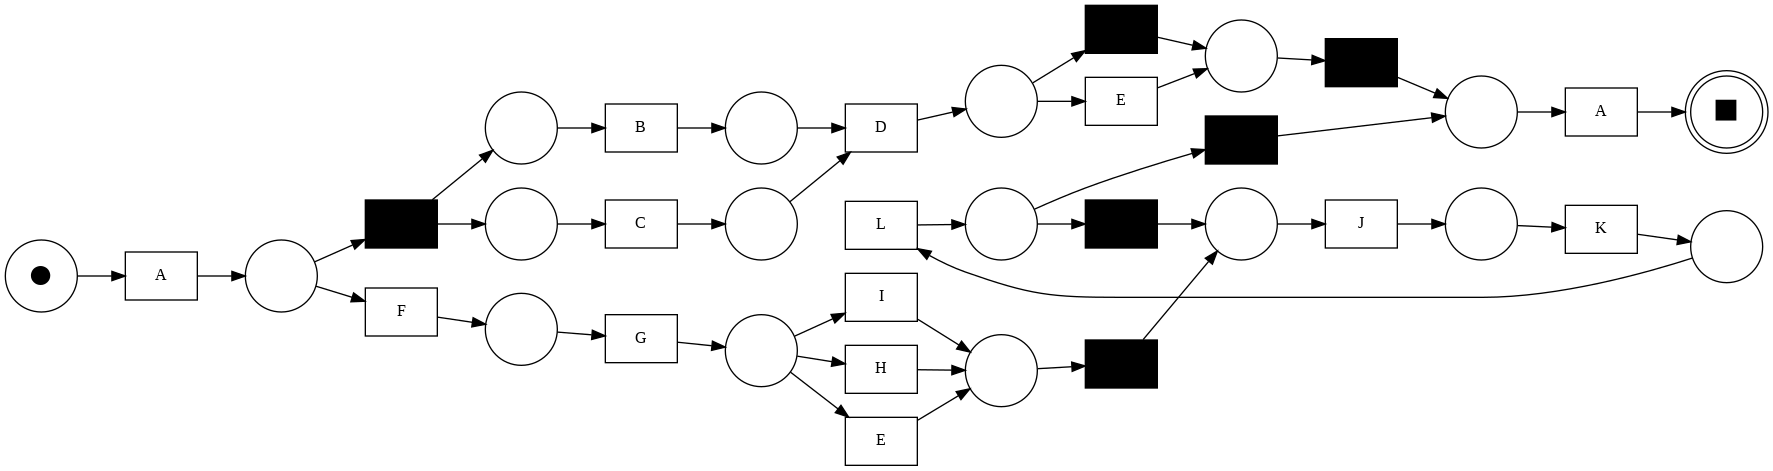

Model to repair:


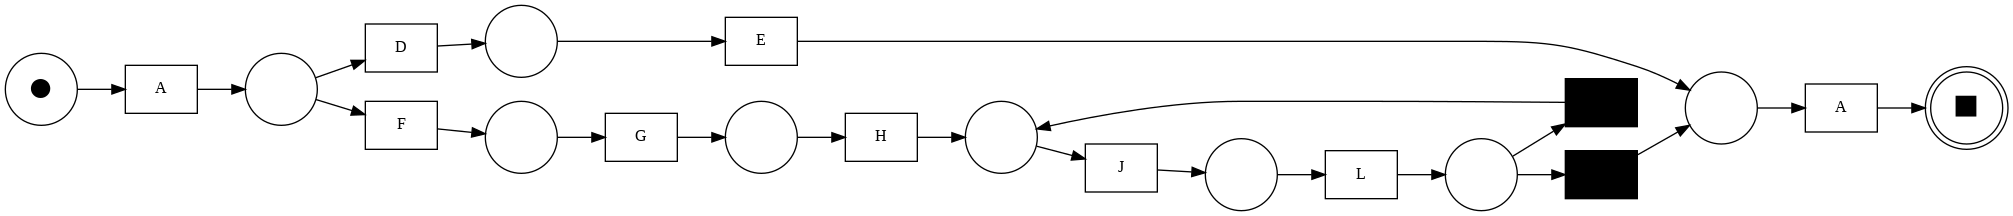

/usr/local/lib/python3.10/dist-packages/pm4py/utils.py:495: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
/usr/local/lib/python3.10/dist-packages/pm4py/utils.py:495: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


aligning log, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/62 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/20 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/24 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/77 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/24 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/62 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/20 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/24 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/77 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/24 [00:00<?, ?it/s]

,Model,Model type,Log,Fitness,Precision,Generalization,Simplicity,Edit Distance,Execution Time Average
0,1,gold,gold,0.999980,0.995300,0.843552,0.787234,None,None
1,1,gold,broken,0.835611,0.716487,0.997199,0.787234,None,None
2,1,gold,combi,0.922181,0.997199,0.876252,0.787234,None,None
3,1,broken,gold,0.765290,0.897019,0.777686,0.913043,None,None
4,1,broken,broken,0.999990,0.998598,0.999211,0.913043,None,None
5,1,broken,combi,0.875823,0.999211,0.823867,0.913043,None,None


In [29]:
# To import other models use this and comment out
# the get_model_gold() and get_model_broken() functions or
# replace their contents with the respective import functions below.
# PATH = 'YOUR_PATH'
# model_gold = get_model_from_bpmn_file(PATH + 'model_M2_gold.bpmn')
# model_broken = get_model_from_bpmn_file(PATH + 'model_M2_broken.bpmn')

# This variable allows to conduct more runs in of the same function.
# The execution time will be averaged over the successive runs.
# In the thesis we used 10.
REPEAT_EVALUATION = 1

# get_model_gold() returns the model N1_gold or M1_gold (they are both encapsulated inside a dictionary)
model_gold = get_model_gold()
# get_model_gold() returns the model N1_broken or M1_broken (they are both encapsulated inside a dictionary)
model_broken = get_model_broken()
print('Model Gold:')
view_petri_net(model_gold)
print('Model to repair:')
view_petri_net(model_broken)

# model_gold fitting logs
model_gold_log = generate_fitting_event_log(model_gold)
# Logs fitting model_broken
model_broken_log = generate_fitting_event_log(model_broken)
# Combined logs
model_combined_log = merge_event_logs(model_gold_log, model_broken_log)

# Create evaluation Dataframe
evaluation_data = evaluation_df(model_gold_log, model_broken_log, model_combined_log, model_gold, MODEL_NAME, 'gold', None)
evaluation_data = pd.concat([evaluation_data, evaluation_df(model_gold_log, model_broken_log, model_combined_log, model_broken, MODEL_NAME, 'broken', None)], ignore_index=True)
evaluation_data



Execution time in seconds: 0.10143589973449707
Execution time avg in seconds: 0.10143589973449707
Model discovered from the model_gold_log using the Inductive Miner:


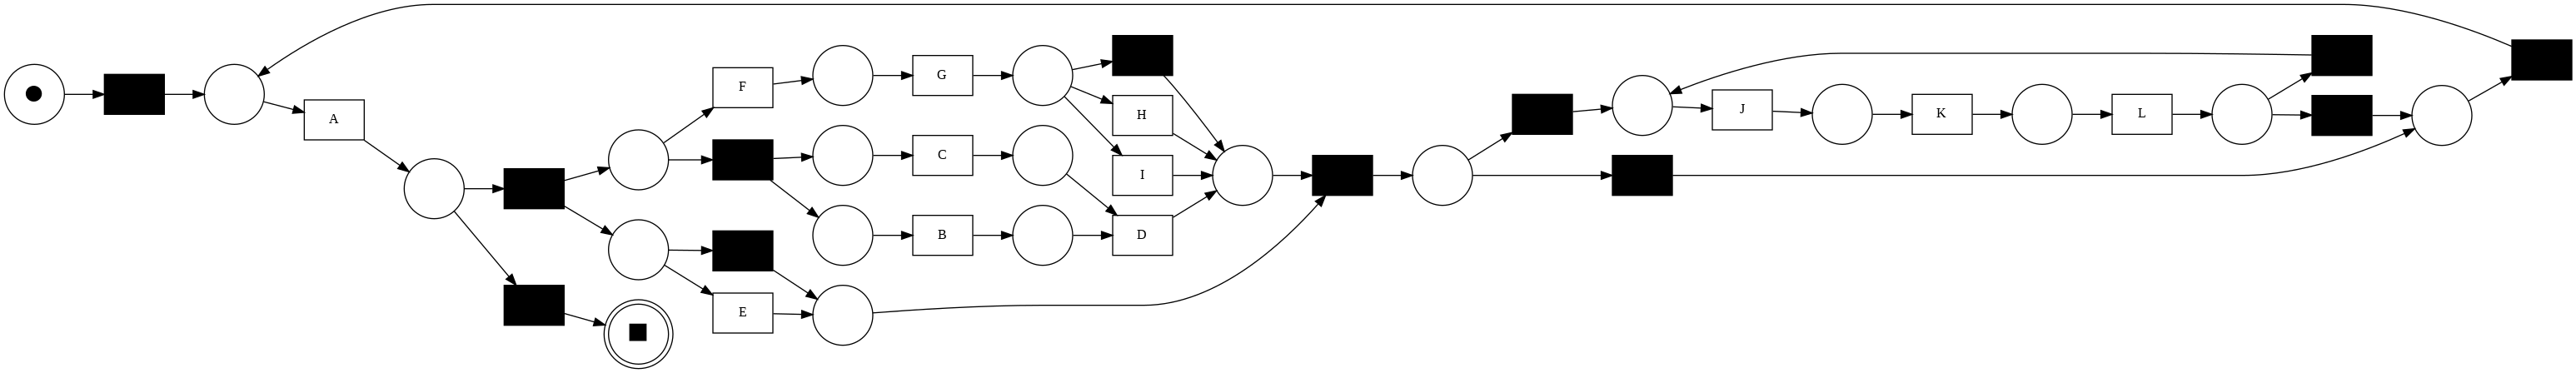

aligning log, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/62 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/20 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/24 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/77 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/24 [00:00<?, ?it/s]

,Model,Model type,Log,Fitness,Precision,Generalization,Simplicity,Edit Distance,Execution Time Average
0,1,gold,gold,0.999980,0.995300,0.843552,0.787234,None,NaN
1,1,gold,broken,0.835611,0.716487,0.997199,0.787234,None,NaN
2,1,gold,combi,0.922181,0.997199,0.876252,0.787234,None,NaN
3,1,broken,gold,0.765290,0.897019,0.777686,0.913043,None,NaN
4,1,broken,broken,0.999990,0.998598,0.999211,0.913043,None,NaN
5,1,broken,combi,0.875823,0.999211,0.823867,0.913043,None,NaN
6,1,inductive,gold,0.999910,0.778595,0.858306,0.733333,None,0.101436
7,1,inductive,broken,0.749245,0.554231,0.776539,0.733333,None,0.101436
8,1,inductive,combi,0.884498,0.776539,0.891167,0.733333,None,0.101436


In [30]:

time_inductive = []
for i in range(0,REPEAT_EVALUATION):
  start_time_inductive = time.time()
  model_inductive = discover_model_inductive(model_gold_log)
  end_time_inductive = time.time()
  time_inductive = np.append(time_inductive, end_time_inductive - start_time_inductive)
  print('Execution time in seconds: ' + str(end_time_inductive - start_time_inductive))

time_inductive_avg = np.mean(time_inductive)
print('Execution time avg in seconds: ' + str(time_inductive_avg))
print('Model discovered from the model_gold_log using the Inductive Miner:')
view_petri_net(model_inductive)

evaluation_data = pd.concat([evaluation_data, evaluation_df(model_gold_log, model_broken_log, model_combined_log, model_inductive, MODEL_NAME, 'inductive', time_inductive_avg)], ignore_index=True)
evaluation_data


Execution time in seconds: 0.14568591117858887
Execution time avg in seconds: 0.14568591117858887
Model discovered from the model_combined_log using the Inductive Miner:


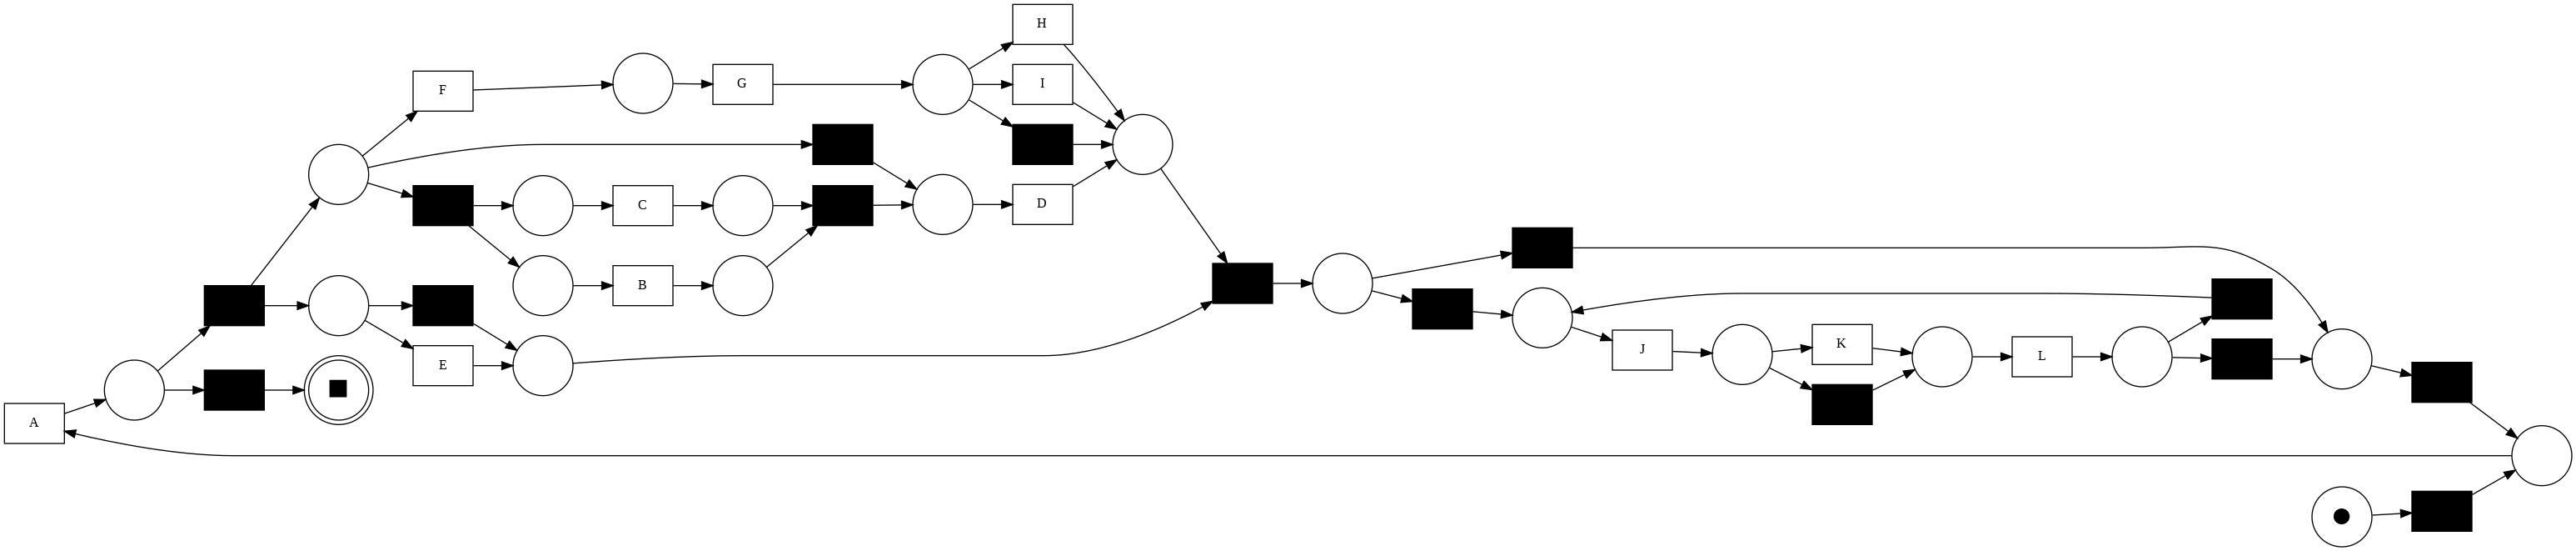

aligning log, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/62 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/20 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/24 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/77 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/24 [00:00<?, ?it/s]

,Model,Model type,Log,Fitness,Precision,Generalization,Simplicity,Edit Distance,Execution Time Average
0,1,gold,gold,0.999980,0.995300,0.843552,0.787234,None,NaN
1,1,gold,broken,0.835611,0.716487,0.997199,0.787234,None,NaN
2,1,gold,combi,0.922181,0.997199,0.876252,0.787234,None,NaN
3,1,broken,gold,0.765290,0.897019,0.777686,0.913043,None,NaN
4,1,broken,broken,0.999990,0.998598,0.999211,0.913043,None,NaN
5,1,broken,combi,0.875823,0.999211,0.823867,0.913043,None,NaN
6,1,inductive,gold,0.999910,0.778595,0.858306,0.733333,None,0.101436
7,1,inductive,broken,0.749245,0.554231,0.776539,0.733333,None,0.101436
8,1,inductive,combi,0.884498,0.776539,0.891167,0.733333,None,0.101436
9,1,inductive_combi,gold,0.999903,0.723614,0.795070,0.705882,None,0.145686


In [31]:
time_inductive_combined = []
for i in range(0,REPEAT_EVALUATION):
  start_time_inductive_combined = time.time()
  model_inductive_combined = discover_model_inductive(model_combined_log)
  end_time_inductive_combined = time.time()
  time_inductive_combined = np.append( time_inductive_combined, end_time_inductive_combined - start_time_inductive_combined)
  print('Execution time in seconds: ' + str(end_time_inductive_combined - start_time_inductive_combined))
time_inductive_combined_avg = np.mean(time_inductive_combined)
print('Execution time avg in seconds: ' + str(np.mean(time_inductive_combined_avg)))

print('Model discovered from the model_combined_log using the Inductive Miner:')
view_petri_net(model_inductive_combined)

evaluation_data = pd.concat([evaluation_data, evaluation_df(model_gold_log, model_broken_log, model_combined_log, model_inductive_combined, MODEL_NAME, 'inductive_combi', time_inductive_combined_avg)], ignore_index=True)
evaluation_data


Checking traces for skips ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Checking traces for sub-traces ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Execution time in seconds: 19.700438022613525
Execution time avg in seconds: 19.700438022613525
Execution time in seconcds: 19.700438022613525
Model mined on the model_gold_log using the Inductive Miner:


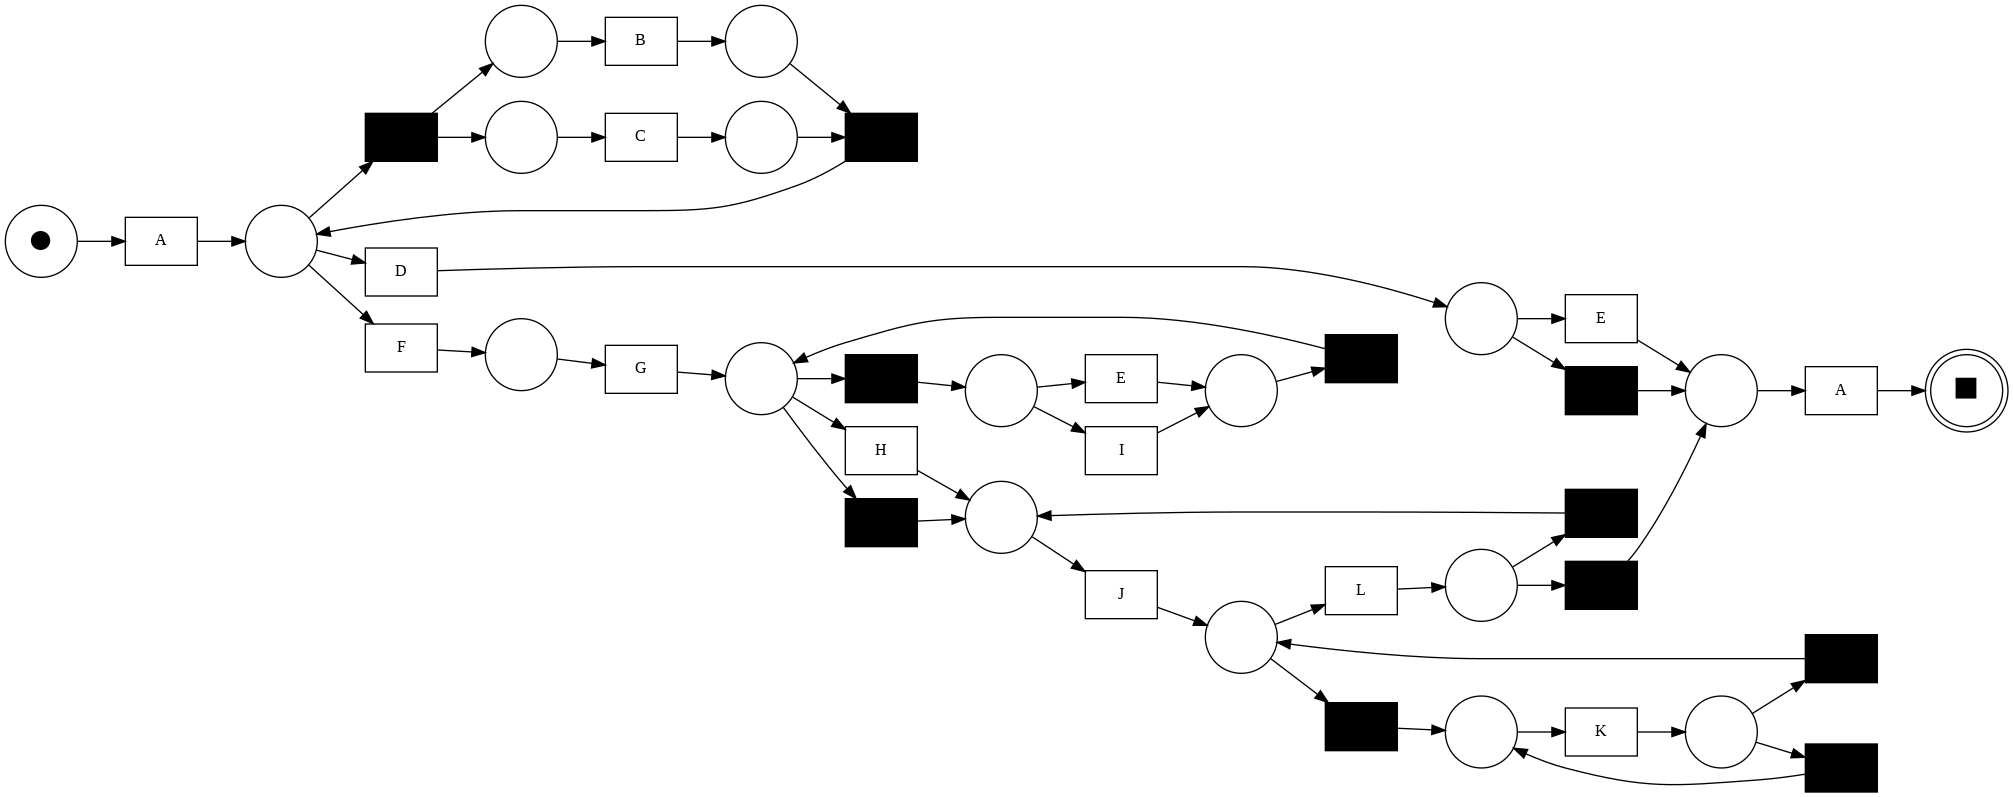

aligning log, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/62 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/20 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/7 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/24 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/77 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/24 [00:00<?, ?it/s]

,Model,Model type,Log,Fitness,Precision,Generalization,Simplicity,Edit Distance,Execution Time Average
0,1,gold,gold,0.999980,0.995300,0.843552,0.787234,None,NaN
1,1,gold,broken,0.835611,0.716487,0.997199,0.787234,None,NaN
2,1,gold,combi,0.922181,0.997199,0.876252,0.787234,None,NaN
3,1,broken,gold,0.765290,0.897019,0.777686,0.913043,None,NaN
4,1,broken,broken,0.999990,0.998598,0.999211,0.913043,None,NaN
5,1,broken,combi,0.875823,0.999211,0.823867,0.913043,None,NaN
6,1,inductive,gold,0.999910,0.778595,0.858306,0.733333,None,0.101436
7,1,inductive,broken,0.749245,0.554231,0.776539,0.733333,None,0.101436
8,1,inductive,combi,0.884498,0.776539,0.891167,0.733333,None,0.101436
9,1,inductive_combi,gold,0.999903,0.723614,0.795070,0.705882,None,0.145686


In [32]:
time_repair = []
for i in range(0,REPEAT_EVALUATION):
  start_time_repaired = time.time()
  model_repaired = repair_process_model(model_broken, model_gold_log)
  end_time_repaired = time.time()
  time_repair = np.append(time_repair, end_time_repaired - start_time_repaired)
  print('Execution time in seconds: ' + str(end_time_repaired - start_time_repaired))
time_repair_avg = np.mean(time_repair)
print('Execution time avg in seconds: ' + str(np.mean(time_repair)))


print('Execution time in seconcds: ' + str(end_time_repaired - start_time_repaired))
print('Model mined on the model_gold_log using the Inductive Miner:')
view_petri_net(model_repaired)
evaluation_data = pd.concat([evaluation_data, evaluation_df(model_gold_log, model_broken_log, model_combined_log, model_repaired, MODEL_NAME, 'repaired', time_repair_avg)], ignore_index=True)
evaluation_data


In [33]:
# Round data in Data frame to two decimals
evaluation_data.round(2)

,Model,Model type,Log,Fitness,Precision,Generalization,Simplicity,Edit Distance,Execution Time Average
0,1,gold,gold,1.00,1.00,0.84,0.79,None,NaN
1,1,gold,broken,0.84,0.72,1.00,0.79,None,NaN
2,1,gold,combi,0.92,1.00,0.88,0.79,None,NaN
3,1,broken,gold,0.77,0.90,0.78,0.91,None,NaN
4,1,broken,broken,1.00,1.00,1.00,0.91,None,NaN
5,1,broken,combi,0.88,1.00,0.82,0.91,None,NaN
6,1,inductive,gold,1.00,0.78,0.86,0.73,None,0.10
7,1,inductive,broken,0.75,0.55,0.78,0.73,None,0.10
8,1,inductive,combi,0.88,0.78,0.89,0.73,None,0.10
9,1,inductive_combi,gold,1.00,0.72,0.80,0.71,None,0.15


In [21]:
nx_model_gold = convert_model_to_networkx(get_model_gold())
nx_model_broken = convert_model_to_networkx(get_model_broken())
nx_model_inductive = convert_model_to_networkx(model_inductive)
nx_model_inductive_combined = convert_model_to_networkx(model_inductive_combined)
nx_model_repaired = convert_model_to_networkx(model_repaired)

# This may not be accurat.
# model_broken and model_repaired may have the same node count since the repair method works in place.
# To fix, just imoirt model_broken again.
print('Node count per model:')
print(f'model_gold: {len(nx_model_gold.nodes)}')
print(f'model_broken: {len(nx_model_broken.nodes)}')
print(f'model_inductive: {len(nx_model_inductive.nodes)}')
print(f'model_inductive_combined: {len(nx_model_inductive_combined.nodes)}')
print(f'model_repaired: {len(nx_model_repaired.nodes)}')

Node count per model:
model_gold: 35
nx_model_broken: 20
nx_model_inductive: 44
nx_model_inductive_combined: 48
nx_model_repaired: 38


These functions can be used to calculate the edit distance. This may take quite long and might not work on other models then N1, since the edit distance also includes matching the places of a Petri net and they might not be named the same in the models compared. Thus, a better implementation of calculating a similarity measure is necessary.

In [24]:
for v in nx.optimize_graph_edit_distance(nx_model_gold, nx_model_gold):
    print(v)

0.0


In [23]:
for v in nx.optimize_graph_edit_distance(nx_model_broken, nx_model_gold):
    print(v)

79.0
77.0
75.0
73.0
71.0
69.0
67.0
65.0
63.0


KeyboardInterrupt: ignored

In [270]:
for v in nx.optimize_graph_edit_distance(nx_model_inductive, nx_model_gold):
    print(v)
# After 10 minutes:
# 99.0
# 97.0
# 95.0
# 93.0
# 91.0
# 89.0

99.0
97.0
95.0
93.0
91.0
89.0


KeyboardInterrupt: ignored

In [21]:
for v in nx.optimize_graph_edit_distance(nx_model_inductive_combined, nx_model_gold):
    print(v)

# 109.0
# 107.0
# 105.0
# 103.0

109.0
107.0
105.0
103.0


KeyboardInterrupt: ignored

In [272]:
for v in nx.optimize_graph_edit_distance(nx_model_repaired, nx_model_gold):
    print(v)
# After 10 minutes
# 94.0
# 92.0
# 90.0
# 88.0
# 86.0

94.0
92.0
90.0
88.0
86.0


KeyboardInterrupt: ignored

System Info:

In [ ]:
!cat /proc/cpuinfo
!cat /proc/meminfo
!cat /etc/*release

#Exports


In [ ]:
MODEL_NAME = '1'

In [ ]:
# Export Event Logs as .xes
pm4py.write_xes(model_gold_log, f'log_gold_{MODEL_NAME}.xes')
pm4py.write_xes(model_gold_log, f'log_broken_{MODEL_NAME}.xes')
pm4py.write_xes(model_gold_log, f'log_combi_{MODEL_NAME}.xes')

In [109]:
# Export BPMN model as .svg
pm4py.save_vis_bpmn(pm4py.convert_to_bpmn(model_repaired['net'], model_repaired['im'], model_repaired['fm']), f"model_repaired_{MODEL_NAME}_bpmn.svg")
pm4py.save_vis_bpmn(pm4py.convert_to_bpmn(model_gold['net'], model_gold['im'], model_gold['fm']), f"model_gold_{MODEL_NAME}_bpmn.svg")
pm4py.save_vis_bpmn(pm4py.convert_to_bpmn(model_broken['net'], model_broken['im'], model_broken['fm']), f"model_broken_{MODEL_NAME}_bpmn.svg")
pm4py.save_vis_bpmn(pm4py.convert_to_bpmn(model_inductive['net'], model_inductive['im'], model_inductive['fm']), f"model_inductive_{MODEL_NAME}_bpmn.svg")
pm4py.save_vis_bpmn(pm4py.convert_to_bpmn(model_inductive_combined['net'], model_inductive_combined['im'], model_inductive_combined['fm']), f"model_inductive_combined_{MODEL_NAME}_bpmn.svg")

In [85]:
# Export Petri nets as .svg
pm4py.save_vis_petri_net(model_gold['net'], model_gold['im'], model_gold['fm'], f"model_gold_{MODEL_NAME}.svg")
pm4py.save_vis_petri_net(model_broken['net'], model_broken['im'], model_broken['fm'], f"model_broken_{MODEL_NAME}.svg")
pm4py.save_vis_petri_net(model_inductive['net'], model_inductive['im'], model_inductive['fm'], f"model_inductive_{MODEL_NAME}.svg")
pm4py.save_vis_petri_net(model_inductive_combined['net'], model_inductive_combined['im'], model_inductive_combined['fm'], f"model_inductive_combined_{MODEL_NAME}.svg")
pm4py.save_vis_petri_net(model_repaired['net'], model_repaired['im'], model_repaired['fm'], f"model_repaired_{MODEL_NAME}.svg")

In [22]:
# Export Petri nets as .pnml
pm4py.write_pnml(model_gold['net'], model_gold['im'], model_gold['fm'], f"model_gold_{MODEL_NAME}.pnml")
pm4py.write_pnml(model_repaired['net'], model_repaired['im'], model_repaired['fm'], f"model_repaired_{MODEL_NAME}.pnml")
pm4py.write_pnml(model_broken['net'], model_broken['im'], model_broken['fm'], f"model_broken_{MODEL_NAME}.pnml")
pm4py.write_pnml(model_inductive['net'], model_inductive['im'], model_inductive['fm'], f"model_inductive_{MODEL_NAME}.pnml")
pm4py.write_pnml(model_inductive_combined['net'], model_inductive_combined['im'], model_inductive_combined['fm'], f"model_inductive_combined_{MODEL_NAME}.pnml")

exporting log, completed traces ::   0%|          | 0/100 [00:00<?, ?it/s]